In [204]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import Sequence
import os
from datetime import datetime
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB4
from keras import layers
from keras import models
from keras.models import Model
from tensorflow.keras.layers.experimental import preprocessing

In [205]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, accuracy_score
from PIL import Image

In [206]:
# Define the root directory where your data is stored
root_directory = "dataset_2_final"

# Get the list of subdirectories (categories)
subdirectories = [subdir for subdir in os.listdir(root_directory) if os.path.isdir(os.path.join(root_directory, subdir))]

# Create lists to store image paths and corresponding labels
image_paths = []
labels = []

# Iterate through each subdirectory (category)
for label, subdirectory in enumerate(subdirectories):
    # Construct the full path to the subdirectory
    subdirectory_path = os.path.join(root_directory, subdirectory)

    # Get a list of image files in the subdirectory
    image_files = [os.path.join(subdirectory_path, filename) for filename in os.listdir(subdirectory_path) if filename.endswith('.jpg')]  # Adjust the file extension as needed
    
    # Append image paths and labels
    image_paths.extend(image_files)
    labels.extend([label] * len(image_files))


# Now you have the image_paths and labels
print("Total images:", len(image_paths))
print("Total labels:", len(labels))

Total images: 494
Total labels: 494


In [207]:
# Define a custom data generator that inherits from the Sequence class
class CustomDataGenerator(Sequence):
    def __init__(self, image_paths, labels, batch_size, image_size):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.image_size = image_size
        self.num_samples = 4 * len(image_paths)
        self.indices = np.arange(self.num_samples)


    def __len__(self):
        
        return int(np.ceil(self.num_samples / self.batch_size))


    def __getitem__(self, index):

        # Determine the range of indices for the current batch
        batch_indices = self.indices[index * self.batch_size : (index + 1) * self.batch_size]


        batch_images = []
        batch_labels = []

        # Iterate over indices in the current batch
        for batch_index in batch_indices:

            # Calculate the index of the original image and the piece index within it
            image_index = batch_index // 4   # Divide by 4 to get original image index
            piece_index = batch_index % 4    # Modulus 4 to get piece index

            # Get the image path and original label for the current image
            image_path = self.image_paths[image_index]
            original_label = self.labels[image_index]
            image_pieces = self.load_image(image_path)

            # Load and split the image into pieces
            piece = image_pieces[piece_index]
            batch_images.append(piece)
            batch_labels.append(original_label)


        batch_images = np.array(batch_images)
        batch_labels = np.array(batch_labels)

        return batch_images, batch_labels

    def load_image(self, image_path):    

        # Load the original image using Pillow
        original_image = Image.open(image_path)
        original_image_array = np.array(original_image)

        # Split the original image into 4 pieces
        h, w, c = original_image_array.shape
        h_half, w_half = h // 2, w // 2
       
        image_pieces = [
            original_image_array[:h_half, :w_half],
            original_image_array[:h_half, w_half:],
            original_image_array[h_half:, :w_half],
            original_image_array[h_half:, w_half:]
        ]
        
        # Resize the image pieces and provide the shape of the output
        resized_images = [tf.image.resize(piece, self.image_size) for piece in image_pieces]

        #Shape of resized image list
        #print(np.array(resized_images).shape)    
        
        return resized_images


In [208]:
batch_size = 16
image_size = (380, 380)  # Adjust the image size based on your model's input requirements

In [209]:
# Split data into training, validation, and test sets
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)
train_paths, val_paths, train_labels, val_labels = train_test_split(train_paths, train_labels, test_size=0.2, random_state=42)

# Create data generators for training, validation, and test sets
train_generator = CustomDataGenerator(train_paths, train_labels, batch_size, image_size)
val_generator = CustomDataGenerator(val_paths, val_labels, batch_size, image_size)
test_generator = CustomDataGenerator(test_paths, test_labels, batch_size, image_size)

In [210]:
# Iterate over batches and print their shapes
for batch_images, batch_labels in train_generator:
    print(f"Batch:")
    print("Batch Images Shape:", batch_images.shape)
    print("Batch Labels Shape:", batch_labels.shape)

Batch:
Batch Images Shape: (16, 380, 380, 3)
Batch Labels Shape: (16,)
Batch:
Batch Images Shape: (16, 380, 380, 3)
Batch Labels Shape: (16,)
Batch:
Batch Images Shape: (16, 380, 380, 3)
Batch Labels Shape: (16,)
Batch:
Batch Images Shape: (16, 380, 380, 3)
Batch Labels Shape: (16,)
Batch:
Batch Images Shape: (16, 380, 380, 3)
Batch Labels Shape: (16,)
Batch:
Batch Images Shape: (16, 380, 380, 3)
Batch Labels Shape: (16,)
Batch:
Batch Images Shape: (16, 380, 380, 3)
Batch Labels Shape: (16,)
Batch:
Batch Images Shape: (16, 380, 380, 3)
Batch Labels Shape: (16,)
Batch:
Batch Images Shape: (16, 380, 380, 3)
Batch Labels Shape: (16,)
Batch:
Batch Images Shape: (16, 380, 380, 3)
Batch Labels Shape: (16,)
Batch:
Batch Images Shape: (16, 380, 380, 3)
Batch Labels Shape: (16,)
Batch:
Batch Images Shape: (16, 380, 380, 3)
Batch Labels Shape: (16,)
Batch:
Batch Images Shape: (16, 380, 380, 3)
Batch Labels Shape: (16,)
Batch:
Batch Images Shape: (16, 380, 380, 3)
Batch Labels Shape: (16,)
Batch:

In [211]:
# Get the number of batches and total number of samples for training, validation, and test generators
num_batches_train = len(train_generator)
num_samples_train = len(train_generator) * batch_size

num_batches_val = len(val_generator)
num_samples_val = len(val_generator) * batch_size

num_batches_test = len(test_generator)
num_samples_test = len(test_generator) * batch_size

# Print the results
print("Training Data:")
print("Number of Batches:", num_batches_train)
print("Total Number of Samples:", num_samples_train)

print("Validation Data:")
print("Number of Batches:", num_batches_val)
print("Total Number of Samples:", num_samples_val)

print("Test Data:")
print("Number of Batches:", num_batches_test)
print("Total Number of Samples:", num_samples_test)


Training Data:
Number of Batches: 79
Total Number of Samples: 1264
Validation Data:
Number of Batches: 20
Total Number of Samples: 320
Test Data:
Number of Batches: 25
Total Number of Samples: 400


In [212]:
# class_labels = ['aca_bd', 'aca_md', 'aca_pd', 'nor', 'scc_bd', 'scc_md', 'scc_pd']


# # Define a function to plot images
# def plot_images(images, labels, class_labels, rows=2, cols=4):
#     plt.figure(figsize=(12, 6))
#     for i in range(rows * cols):
#         plt.subplot(rows, cols, i + 1)
#         plt.imshow(images[i].astype(np.uint8))
#         plt.title(class_labels[labels[i]])
#         plt.axis('off')
#     plt.tight_layout()
#     plt.show()

# # Number of images to show for visualization
# num_images_to_show = 8


# # Validation evaluation
# for batch_idx in range(len(train_generator)):
#     batch_images, batch_labels = val_generator[batch_idx]  # Get a batch from the validation generator
    
#     # Visualize random validation batch
#     random_indices = np.random.choice(batch_images.shape[0], num_images_to_show, replace=False)
#     random_images = batch_images[random_indices]
#     random_labels = batch_labels[random_indices]
#     plot_images(random_images, random_labels, class_labels)

In [213]:
# Print the dimensions of the batches

for images, labels in val_generator:
    print(images.shape)
    print(labels.shape)
    break

(16, 380, 380, 3)
(16,)


In [214]:
base_model = EfficientNetB4(include_top = False ,weights='imagenet', pooling='avg')

# Introduce a layer of data augmentation
data_augmentation = Sequential([
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomContrast(0.2),
    preprocessing.RandomTranslation(0.2, 0.2),    
])


# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False
# Unfreeze the last 10 layers in the base model for fine-tuning
for layer in base_model.layers[-10:]:
    layer.trainable = True


#capa de entradas. I think I dont need it
entradas = layers.Input((380, 380, 3))
# Capa de augmentation
x = data_augmentation(entradas)
# Pass the augmented images through the base model
x = base_model(x)
# Add a dense layer
x = layers.Dense(512, activation='relu')(x)
# Add another dense layer
salidas = layers.Dense(7, activation='softmax')(x)



model = Model(inputs = entradas, outputs = salidas)
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 380, 380, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 380, 380, 3)       0         
_________________________________________________________________
efficientnetb4 (Functional)  (None, 1792)              17673823  
_________________________________________________________________
dense (Dense)                (None, 512)               918016    
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 3591      
Total params: 18,595,430
Trainable params: 3,236,871
Non-trainable params: 15,358,559
_________________________________________________________________


In [215]:
tf.keras.backend.clear_session()

In [216]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipvalue=0.5)

In [217]:
from tensorflow.keras.callbacks import Callback

class DebuggingCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Debugging steps go here
        print("Epoch:", epoch)
        
        # Print information about validation data generator behavior
        num_batches_val = len(val_generator)
        print("Number of Batches for Validation:", num_batches_val)
        
        # Evaluate validation data and print metrics
        val_loss, val_accuracy = self.model.evaluate(val_generator, verbose=0)
        print("Validation Loss:", val_loss)
        print("Validation Accuracy:", val_accuracy)
        
        # Print predictions and labels for a few batches
        num_batches_to_visualize = 1
        for batch_idx in range(num_batches_to_visualize):
            batch_images, batch_labels = val_generator[batch_idx]
            predictions = self.model.predict(batch_images)
            predicted_classes = np.argmax(predictions, axis=-1)
            print("Batch", batch_idx)
            print("Predicted Labels:", predicted_classes)
            print("True Labels:", batch_labels)
        
        # Visualize images and predictions for a few batches
        num_images_to_visualize = 1
        for batch_idx in range(num_batches_to_visualize):
            batch_images, batch_labels = val_generator[batch_idx]
            predictions = self.model.predict(batch_images)
            predicted_classes = np.argmax(predictions, axis=-1)

            for i in range(num_images_to_visualize):
                
                plt.imshow(batch_images[i])   
                # Assuming your image is loaded as 'image'
                normalized_image = batch_images[i] / 255.0  # Normalize to [0, 1]
                plt.imshow(normalized_image)                
                plt.title(f"True Label: {batch_labels[i]}, Predicted Label: {predicted_classes[i]}")
                plt.show()


In [218]:

# Create an instance of the DebuggingCallback
debugging_callback = DebuggingCallback()

# Train the model using the custom data generators and the debugging callback
history = model.fit(train_generator, epochs=50, validation_data=val_generator, shuffle=True, callbacks=[])


Epoch 1/50
79/79 [==============================] - 185s 2s/step - loss: 1.7410 - accuracy: 0.3426 - val_loss: 1.7774 - val_accuracy: 0.3924
Epoch 2/50
79/79 [==============================] - 137s 2s/step - loss: 1.5065 - accuracy: 0.4391 - val_loss: 1.3817 - val_accuracy: 0.5032
Epoch 3/50
79/79 [==============================] - 149s 2s/step - loss: 1.2848 - accuracy: 0.5261 - val_loss: 1.3416 - val_accuracy: 0.4937
Epoch 4/50
79/79 [==============================] - 200s 3s/step - loss: 1.2756 - accuracy: 0.5261 - val_loss: 1.2743 - val_accuracy: 0.5475
Epoch 5/50
79/79 [==============================] - 180s 2s/step - loss: 1.1263 - accuracy: 0.5704 - val_loss: 1.0431 - val_accuracy: 0.6297
Epoch 6/50
79/79 [==============================] - 161s 2s/step - loss: 1.0794 - accuracy: 0.5949 - val_loss: 1.0600 - val_accuracy: 0.6614
Epoch 7/50
79/79 [==============================] - 133s 2s/step - loss: 1.0426 - accuracy: 0.6266 - val_loss: 1.0981 - val_accuracy: 0.6392
Epoch 8/50
79

In [219]:
history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [220]:
folder_date = 'old_models/' +  datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")
os.mkdir(folder_date)
filepath_model = folder_date + '/my_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'

In [221]:
#Guardo el modelo en la última epoch
model.save(folder_date + '/modelo_entrenado.h5')

c:\Users\diosdadj\Anaconda3\envs\ml\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


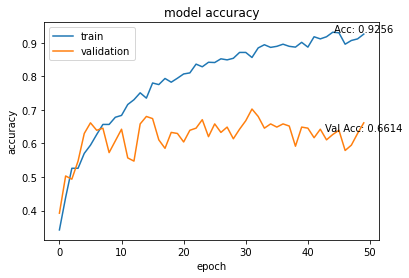

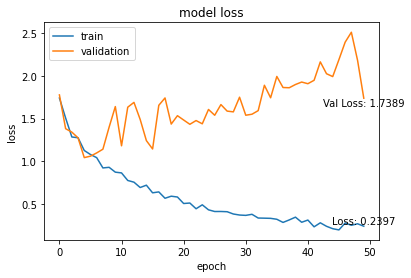

In [222]:
print(history.history.keys())

#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.text(len(history.history['accuracy'])-1, history.history['accuracy'][-1], 
         f"Acc: {history.history['accuracy'][-1]:.4f}", ha='center', va='bottom')
plt.text(len(history.history['val_accuracy'])-1, history.history['val_accuracy'][-1], 
         f"Val Acc: {history.history['val_accuracy'][-1]:.4f}", ha='center', va='top')


plt.savefig(folder_date + "/accuracy.png")
plt.show()

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.text(len(history.history['loss'])-1, history.history['loss'][-1], 
         f"Loss: {history.history['loss'][-1]:.4f}", ha='center', va='bottom')
plt.text(len(history.history['val_loss'])-1, history.history['val_loss'][-1], 
         f"Val Loss: {history.history['val_loss'][-1]:.4f}", ha='center', va='top')


plt.savefig(folder_date + "/loss.png")
plt.show()


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 3, 0, 1, 1, 0, 0, 0, 0, 0, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 3, 2, 2, 5, 3, 2, 6, 6, 2, 6, 2, 2, 4, 2, 2, 1, 2, 2, 3, 2, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 2, 1, 3, 6, 6, 3, 3, 3, 3, 3, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 6, 6, 4, 4, 4, 4, 6, 4, 3, 5, 6, 4, 5, 4, 5, 5, 5, 5, 2, 2, 6, 2, 5, 6, 5, 6, 4, 4, 4, 6, 6, 6, 6, 4, 5, 6, 5, 6, 6, 6, 4, 6, 6, 6, 6, 6, 6, 6]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]


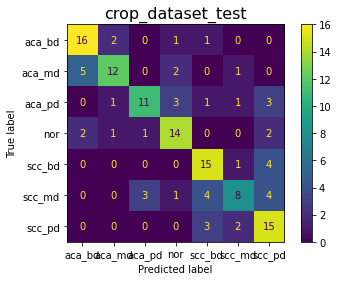

Precision: 0.6602501535731348
Recall: 0.65
Accuracy: 0.65


In [223]:
# Load the test images from the folder 'test_images'
predicted_labels= []
true_labels = []
directory = "crop_dataset_test"


label_mapping = {
    'aca_bd': 0,
    'aca_md': 1,
    'aca_pd': 2,
    'nor' : 3,
    'scc_bd' : 4,
    'scc_md' : 5, 
    'scc_pd' : 6
}


for filename in os.listdir(directory):

    # Load the image and add it to the list of test images
    f = os.path.join(directory, filename)
    imagen = tf.keras.preprocessing.image.load_img(f, target_size=(380,380))
    x = tf.keras.preprocessing.image.img_to_array(imagen)    
    x = np.expand_dims(x, axis=0)

    prediction = model.predict(x)
    predicted_class = np.argmax(prediction)

    #True labels are calculated based on name. It is a very weak way of doing it. Look for a better one or rename the files

    if 'aca_bd' in filename:
        true_labels.append(0)
    elif 'aca_md' in filename:
        true_labels.append(1)
    elif 'aca_pd' in filename:
        true_labels.append(2)
    elif 'nor' in filename:
        true_labels.append(3)
    elif 'scc_bd' in filename:
        true_labels.append(4)    
    elif 'scc_md' in filename:
        true_labels.append(5)
    elif 'scc_pd' in filename:
        true_labels.append(6)
    
    predicted_labels.append(predicted_class)

print(predicted_labels)
print(true_labels)


cm = confusion_matrix(true_labels, predicted_labels)
labels = [label for label, _ in sorted(label_mapping.items(), key=lambda x: x[1])]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

plt.title(directory,  fontdict={'fontsize': 16})  # Set the new title for the plot
plt.show()


# Calculate precision, recall, and accuracy
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
accuracy = accuracy_score(true_labels, predicted_labels)

# Print the results
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)
